# Advnaced Python: Individual Assignment
## MBD O2
### Sara Krumpak


#### Bike Sharing Rental Prediction

For this assignment I will be reusing the code my group (group D) in term 2 made for the final assignment regarding Bike Sharing Rental Predictions. 

In the bike sharing rental prediction assignment, we are dealing with a regression problem. We will use different regression models to try and predict how many bikes will be rented on a specific day. 

Originally, we get two datasets with daily and hourly bike sharing trends. I will be focusing on how bike sharing trends evolved through out the day with the hourly data. 

### Import Libraries and Data

In [1]:
import webbrowser
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
from dask.distributed import Client
from dask_ml.datasets import make_regression
from dask_ml.preprocessing import DummyEncoder
from dask_ml.linear_model import LinearRegression
from dask_ml.xgboost import XGBRegressor
from sklearn.externals.joblib import parallel_backend
import dask_xgboost
import xgboost


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### Importing Datasets

In [2]:
# Open dataset on the web
web_file = webbrowser.open('https://raw.githubusercontent.com/sarakrumpak/Advanced-Python-Individual-Assignment/master/hour.csv?token=AKQXI7YUF723XKQ34OOAJ3K44F2N2')

In [3]:
web_file

True

In [4]:
# Load dataset
df = dd.read_csv("/Users/sarakrumpak/Documents/IE Business School/MBD/Term 3/Advanced Python/Assignments/Individual Assignment/Bike-Sharing-Dataset 2/hour.csv")

In [5]:
# Set index
df = df.set_index("instant")

In [6]:
# Get some basic information regarding the dataframe
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, dteday to cnt
dtypes: object(1), float64(4), int64(11)

In [7]:
# Preview the dataset
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## 1. Preprocessing

### Identifying null values
##### According to the code below this dataset does not have any null value.

In [8]:
df.isna().sum().compute()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### We will rename some columns in order to better identify them

In [9]:
# Rename columns
df = df.rename(
    columns={
        "dteday": "datetime",
        "weathersit": "weather_condition",
        "cnt": "total_bike_rented",
    },
)

In [10]:
# Check that the columns have been properly renamed
df.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,atemp,hum,windspeed,casual,registered,total_bike_rented
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Column type modifications:

Taking a look at the dataset information, we see that some columns are not in the appropriate data type. For instance, datetime is an object while it should be in date format. Also, we have some columns that are integers but in reality should be categorical.

In [11]:
# Check column types
df.dtypes

datetime              object
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weather_condition      int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
total_bike_rented      int64
dtype: object

In [12]:
# Change datetime to datetime
df["datetime"] = dd.to_datetime(df.datetime)

In [13]:
# Identify columns that need to be transformed to categorical
features_to_transform = [
    "season",
    "yr",
    "mnth",
    "hr",
    "holiday",
    "weekday",
    "workingday",
    "weather_condition",
]

In [14]:
# Function to transform category type
def type_shifter(df, features, new_type):
    """this function takes the selected features of a data frame and 
    cast them to the new_type"""
    for i in features:
        df[i] = df[i].astype(new_type)
    return df.info()

In [15]:
# Apply function to dataset
type_shifter(df, features_to_transform, "category")

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, datetime to total_bike_rented
dtypes: category(8), datetime64[ns](1), float64(4), int64(3)

In [16]:
# Check column types
df.dtypes

datetime             datetime64[ns]
season                     category
yr                         category
mnth                       category
hr                         category
holiday                    category
weekday                    category
workingday                 category
weather_condition          category
temp                        float64
atemp                       float64
hum                         float64
windspeed                   float64
casual                        int64
registered                    int64
total_bike_rented             int64
dtype: object

### Renaming the categorical variables levels:

In the original dataset all the weekdays and months are presented as integer, although we have already casted them to categorical type, in order to make them more informative, we will change the level names:

In [17]:
df["weekday"] = df["weekday"].map(
    {
        0: "Sunday",
        1: "Monday",
        2: "Tuesday",
        3: "Wednesday",
        4: "Thursday",
        5: "Friday",
        6: "Saturday",
    }
)

**Here we will check which season is which number based on the unique months based on that season**

In [18]:
df[df["season"] == 1]["mnth"].unique()  # Seems like Winter

Dask Series Structure:
npartitions=1
    category[unknown]
                  ...
Name: mnth, dtype: category
Dask Name: unique-agg, 42 tasks

In [19]:
df[df["season"] == 2]["mnth"].unique()  # Seems like Spring

Dask Series Structure:
npartitions=1
    category[unknown]
                  ...
Name: mnth, dtype: category
Dask Name: unique-agg, 42 tasks

In [20]:
df[df["season"] == 3]["mnth"].unique()  # Seems like Summer

Dask Series Structure:
npartitions=1
    category[unknown]
                  ...
Name: mnth, dtype: category
Dask Name: unique-agg, 42 tasks

In [21]:
df[df["season"] == 4]["mnth"].unique()  # Seems like Autumn

Dask Series Structure:
npartitions=1
    category[unknown]
                  ...
Name: mnth, dtype: category
Dask Name: unique-agg, 42 tasks

In [22]:
# Label the season column values
df["season"] = df["season"].map({1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})

In [23]:
# Label the month column values
df["mnth"] = df["mnth"].map(
    {
        1: "01-Jan",
        2: "02-Feb",
        3: "03-Mar",
        4: "04-Apr",
        5: "05-May",
        6: "06-Jun",
        7: "07-Jul",
        8: "08-Aug",
        9: "09-Sep",
        10: "10-Oct",
        11: "11-Nov",
        12: "12-Dec",
    }
)

In [24]:
# Label the year column values 
df["yr"] = df["yr"].map({0: "2011", 1: "2012"})

In [25]:
df["weather_condition"] = df["weather_condition"].map({1: "A", 2: "B", 3: "C", 4: "D"})

In [26]:
# Check dataset
df.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,atemp,hum,windspeed,casual,registered,total_bike_rented
instant,,,,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.2879,0.75,0.0,0,1,1


### 2. Visualizations
In order to see if there is any specific trend in different time intervals we present the target variable over month, day and hour to get a more clear vision of the target variable evolution.

In [27]:
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "large",
    "axes.titlesize": "large",
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
}

plt.rcParams.update(params)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


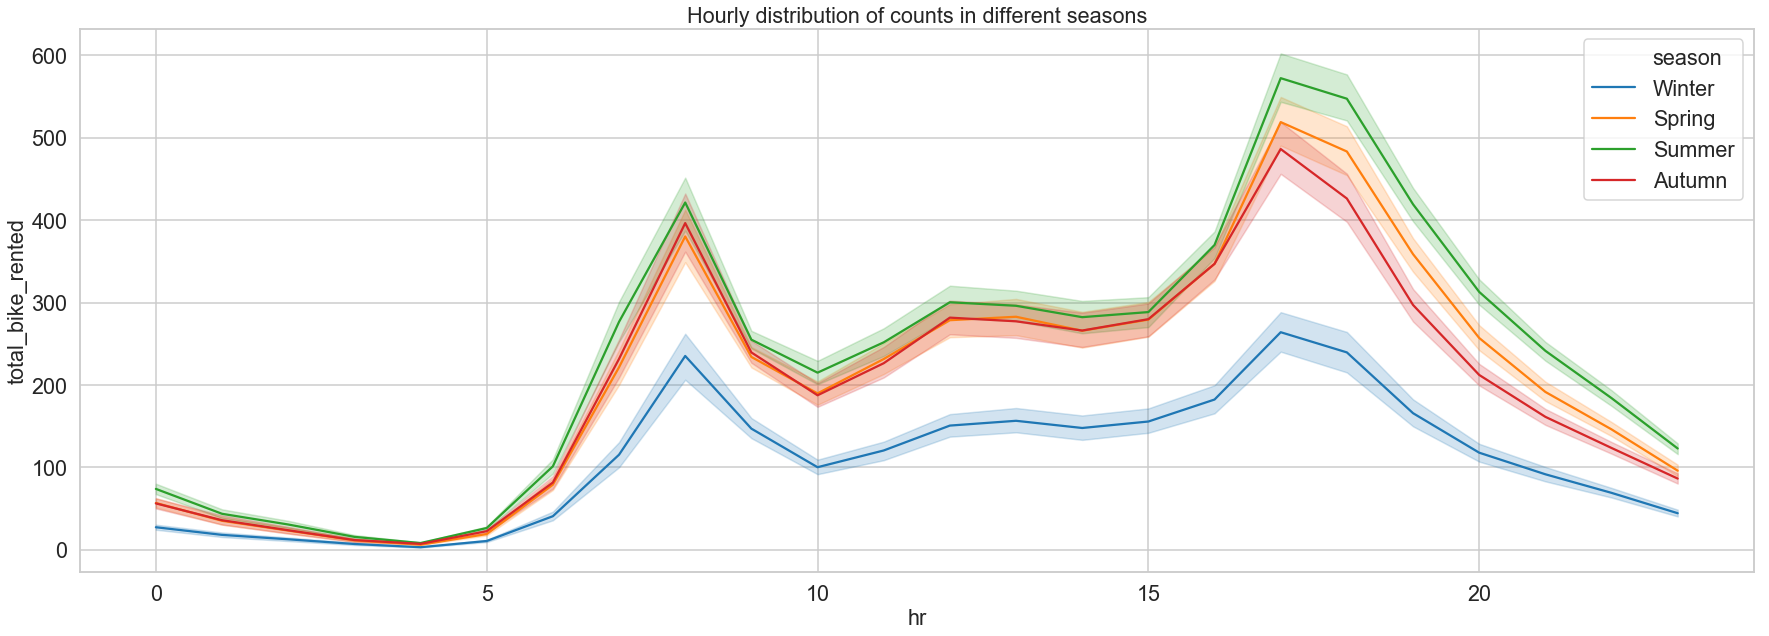

In [28]:
# Hourly distribution over seasons
fig, ax = plt.subplots()
sns.lineplot(
    data=df[["hr", "total_bike_rented", "season"]].compute(),
    x="hr",
    y="total_bike_rented",
    hue="season",
    ax=ax,
)
ax.set(title="Hourly distribution of counts in different seasons");

**The graph shows and interesting pattern. On average the bike renting goes up in the morning and afternoon. Probably due to the morning and afternoon commute to work. At the same time it shows that the rentals go down during the Winter (because of the cold) and increases during the Spring and Summer months.**

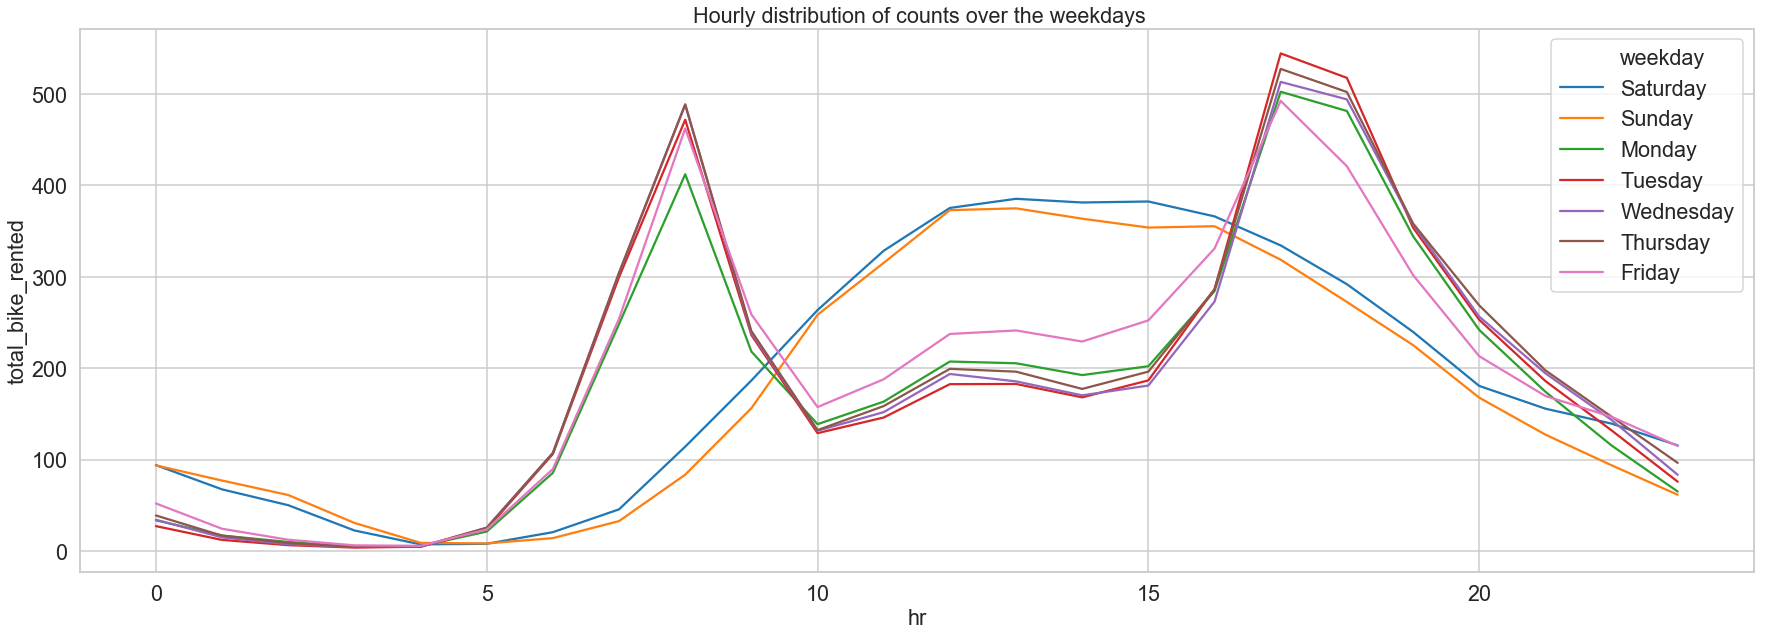

In [29]:
# Daily hourly distribution
fig, ax = plt.subplots()
sns.lineplot(
    data=df[["hr", "total_bike_rented", "weekday"]].compute(),
    x="hr",
    y="total_bike_rented",
    hue="weekday",
    ax=ax,
    err_style=None,
)
ax.set(title=" Hourly distribution of counts over the weekdays");

**Changing the graph to show daily usage, we can see another interesting thing. The graph over the weekdays follow the seasonal chart above. Meaning that a lot of the bike rentals might have something to do with the Morning and Afternoon commute. But during the weekends, those spikes dissappear and there is a bulge during noon hours. This reinforces our hypothesis that the spikes are related to the work commute. During the weekends the rentals are more about leasure trips on the bikes.**

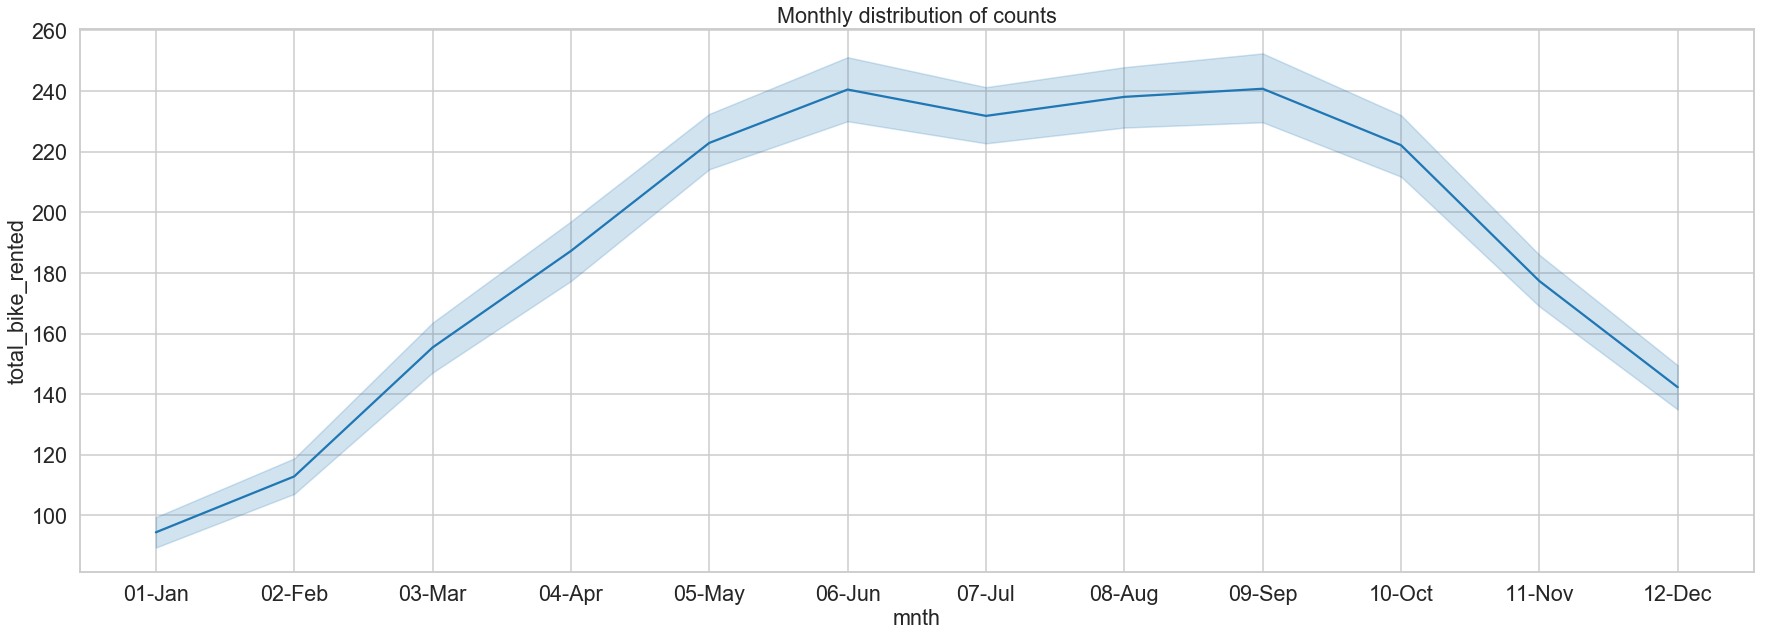

In [30]:
# Average Monthly Rentals
fig, ax = plt.subplots()
sns.lineplot(
    data=df[["mnth", "total_bike_rented", "yr"]].compute(), x="mnth", y="total_bike_rented", ax=ax
)
ax.set(title="Monthly distribution of counts");

**This graph shows the average rentals per month and we can see that the rental increases in the summer and decreases in the winter**

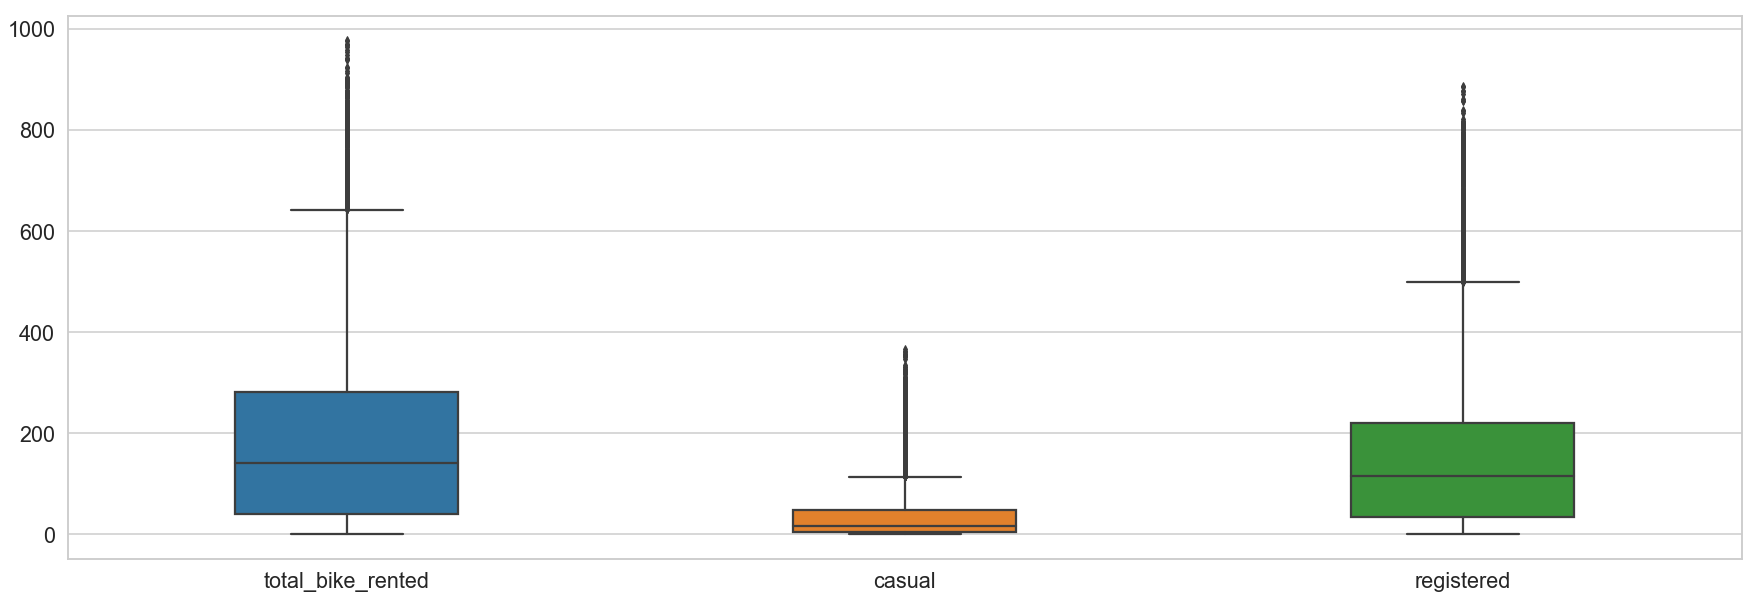

In [31]:
# Boxplot of total bikes rented
fig, ax = plt.subplots()
sns.boxplot(data=df[["total_bike_rented", "casual", "registered"]].compute(), ax=ax, width=0.4)

### 3. Features correlation

In order to avoid futrther error in the modeling part it is better to remove potential multicollinearity between features; therefore, we should measure the correlation coefficient between different featuers.

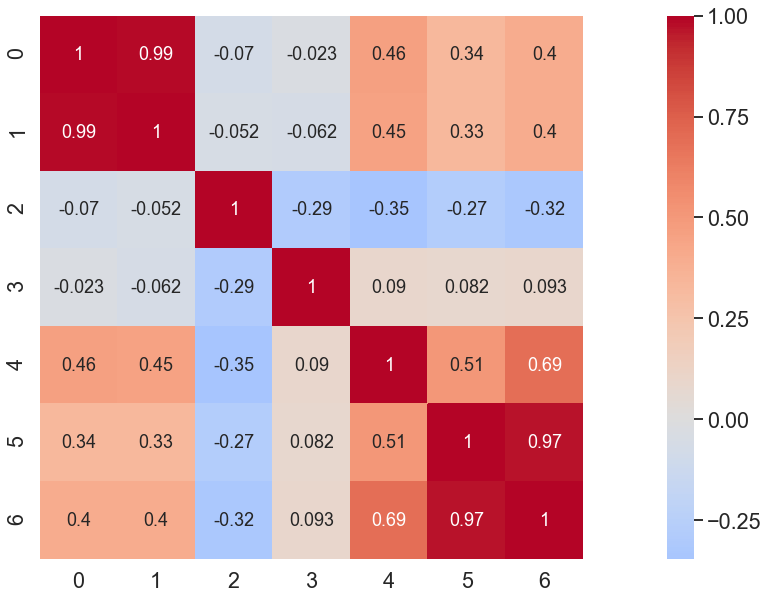

In [32]:
correlation = df[
    ["temp", "atemp", "hum", "windspeed", "casual", "registered", "total_bike_rented"]
].corr()
# correlation.style.background_gradient(cmap='GnBu').set_precision(2)
sns.heatmap(correlation, cmap="coolwarm", square=True, center=0, annot=True);

##### As could be seen above atemp and temp are highly correlated so we will only keep temp and drop the atem from the dataset and other side we cannot say that anu other feature is absolutely useless for Predicting the target Variable so we will keep the other numeric features.

In [33]:
# Drop atemp
df = df.drop("atemp", axis=1)

In [34]:
# Check dataset
df.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,hum,windspeed,casual,registered,total_bike_rented
instant,,,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.81,0.0,3,13,16
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.80,0.0,8,32,40
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.80,0.0,5,27,32
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.75,0.0,3,10,13
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.75,0.0,0,1,1


###### Casual and registered are a division of total bikes rented so we canot use them to predict the total bikes rented or our model will be a sum of both

In [35]:
df = df.drop("casual", axis=1)
df = df.drop("registered", axis=1)

In [36]:
df.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,hum,windspeed,total_bike_rented
instant,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.81,0.0,16
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.80,0.0,40
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.80,0.0,32
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.75,0.0,13
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.75,0.0,1


### 4. Exploring numeric features:

Linear regression algorithm is highly sensitive to the numerical features distribution and also outliers. It means if numeric features are highly skewd probably the regression model would be affected in a negative way. Outliers also are quiet important, and having some outliers in a linear model could change the result totally; therefore in this part we focus on cleaning the numeric values.

In [37]:
# Show only numerical columns
numeric_cols = df._get_numeric_data().columns
numeric_cols

Index(['temp', 'hum', 'windspeed', 'total_bike_rented'], dtype='object')

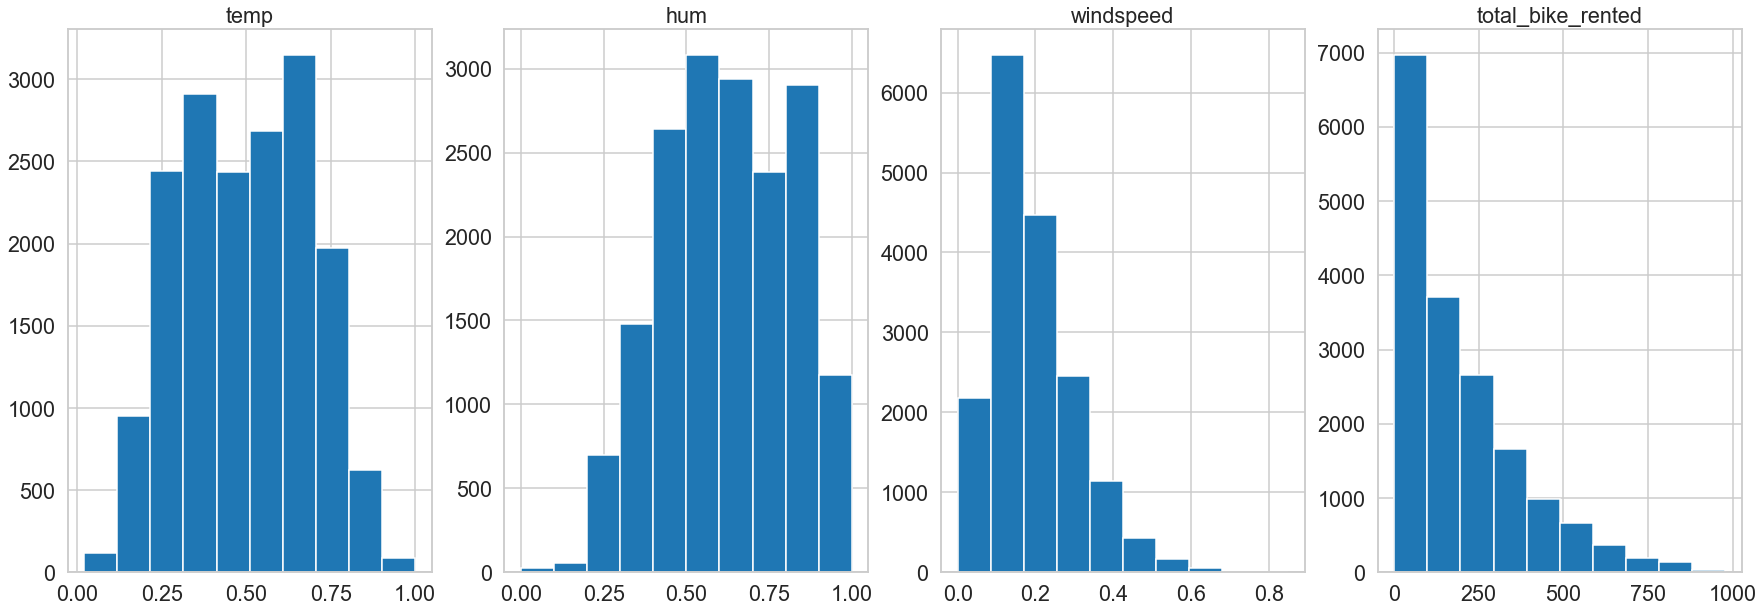

In [38]:
counter = 1
for i in numeric_cols.values:
    plt.subplot(1, len(numeric_cols), counter)
    plt.hist(df[i].compute())
    plt.title(str(i))
    counter += 1

#### Considering the sensitivity of the Linear regression model to numeric features skewness, we will try to modifiy this by transforming variables with skewness higher than our threshold.

In [39]:
from dask.array import stats

###### As could be seen above our target variable is highly skewed and needs to get transformed. Doing so, we take sqaure root of the target variable and the skewness would be in the acceptabel range now:

In [40]:
skew(np.log(df.total_bike_rented))

-0.9361009597655617

#### As log transformation in this case cannot remove the skewness we try with sqrt

In [41]:
skew(np.sqrt(df.total_bike_rented))

0.28644988648376024

In [42]:
df["total_bike_rented"] = np.sqrt(df.total_bike_rented)
df.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weather_condition,temp,hum,windspeed,total_bike_rented
instant,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,01-Jan,0,0,Saturday,0,A,0.24,0.81,0.0,4.000000
2,2011-01-01,Winter,2011,01-Jan,1,0,Saturday,0,A,0.22,0.80,0.0,6.324555
3,2011-01-01,Winter,2011,01-Jan,2,0,Saturday,0,A,0.22,0.80,0.0,5.656854
4,2011-01-01,Winter,2011,01-Jan,3,0,Saturday,0,A,0.24,0.75,0.0,3.605551
5,2011-01-01,Winter,2011,01-Jan,4,0,Saturday,0,A,0.24,0.75,0.0,1.000000


#### Outliers:

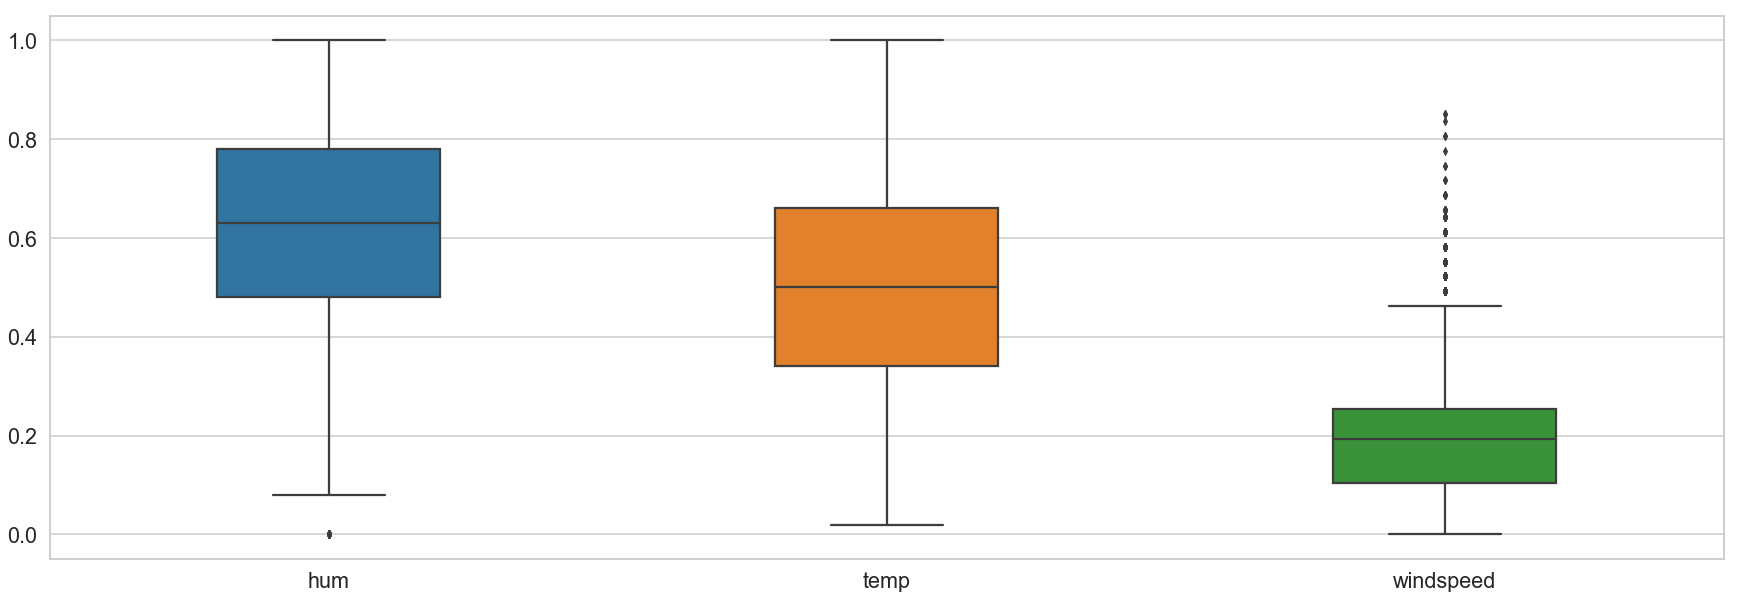

In [43]:
fig, ax = plt.subplots()
sns.boxplot(data=df[["hum", "temp", "windspeed"]].compute(), ax=ax, width=0.4);

#### Exploring the boxplots for univariate analysis of outliers it seems that the numeric features containing outliers are hum and windspeed, however it is not enough yet to consider those points outliers. Therefore we do a multivariate analysis of windspeed and target variable to see if we can get more information.

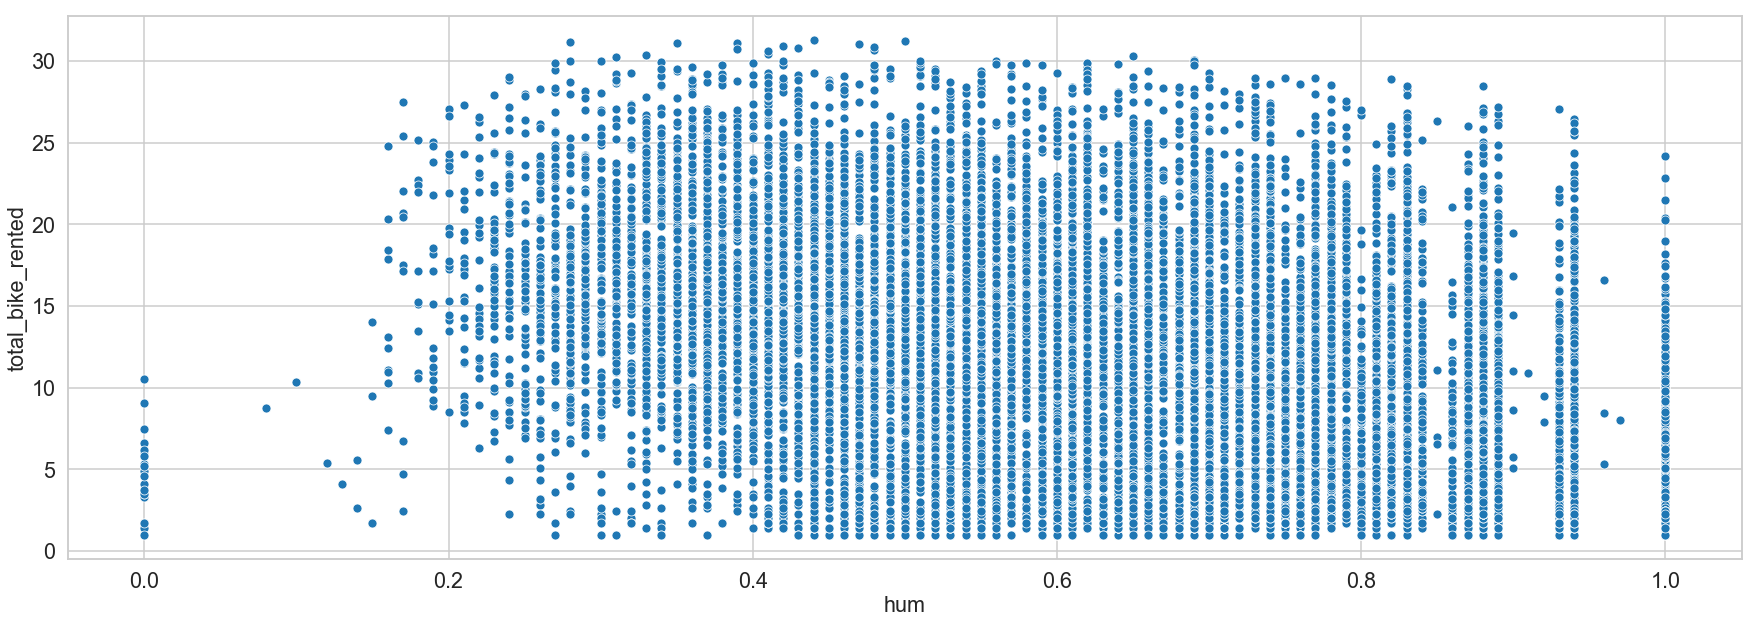

In [44]:
sns.scatterplot(df["hum"].compute(), df["total_bike_rented"].compute())

In [45]:
df['hum'].compute().clip(lower=0.1, inplace=True)

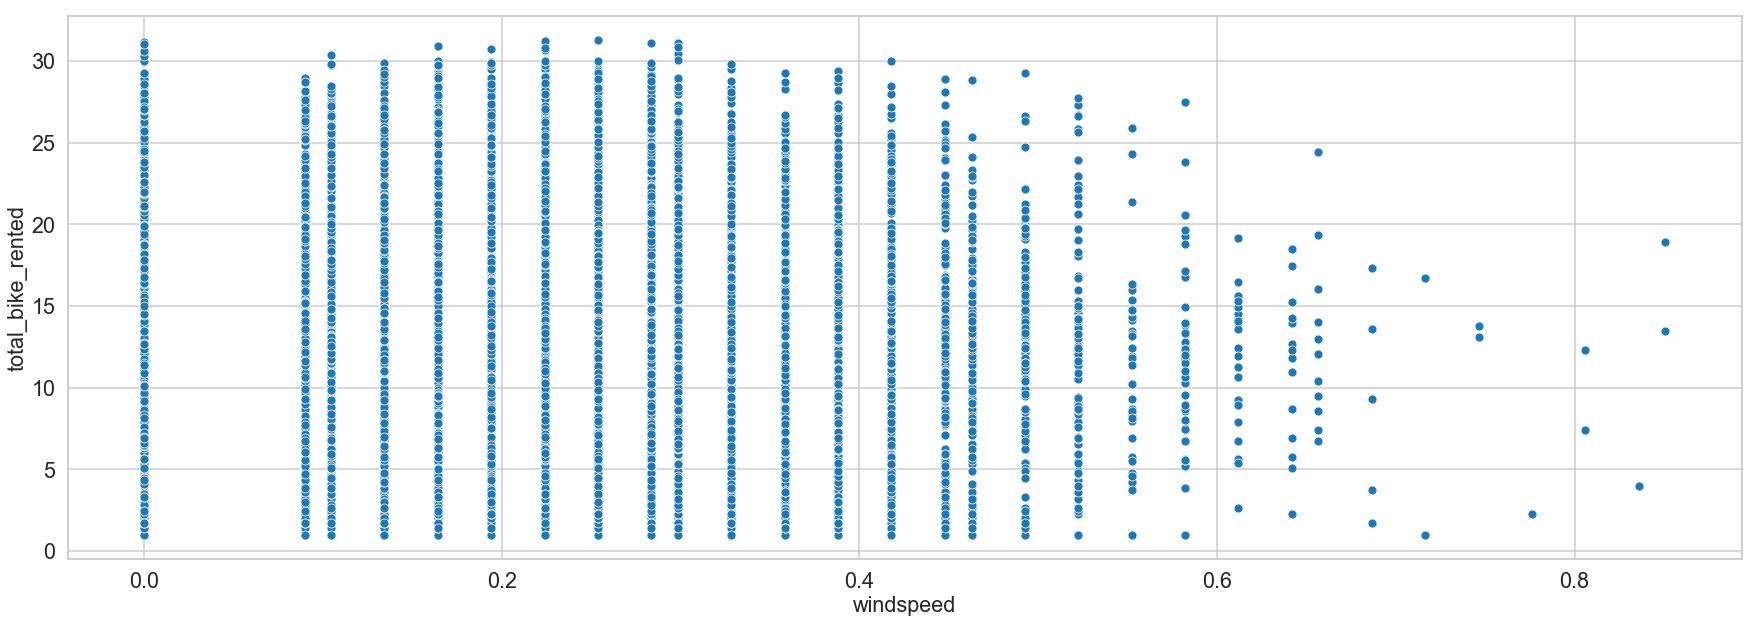

In [46]:
sns.scatterplot(df["windspeed"].compute(), df["total_bike_rented"].compute());

##### The above scatter plot shows that probably winspeed values over 0.7 could be consider outliers, therefore our strategy at this point is to clip the windspeed values over 0.7 to o.7.

In [47]:
df["windspeed"].compute().clip(upper=0.7, inplace=True)

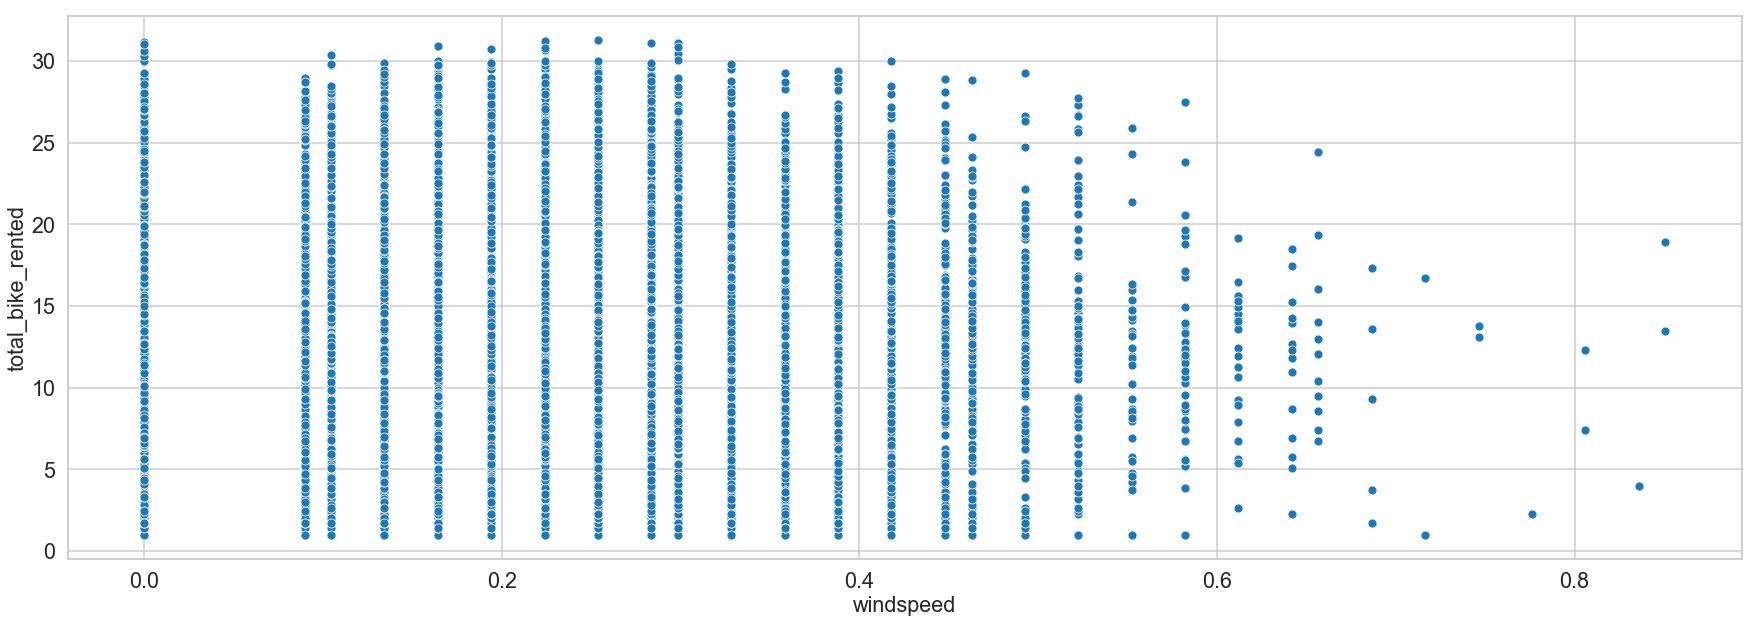

In [48]:
sns.scatterplot(df["windspeed"].compute(), df["total_bike_rented"].compute());

#### Converting categoriacal features to dummy variables.

In [49]:
df = dd.get_dummies(df.categorize()).compute()

In [50]:
# Check dataset
df.head()

,datetime,temp,hum,windspeed,total_bike_rented,season_Winter,season_Spring,season_Summer,season_Autumn,yr_2011,...,weekday_Tuesday,weekday_Wednesday,weekday_Thursday,weekday_Friday,workingday_0,workingday_1,weather_condition_A,weather_condition_B,weather_condition_C,weather_condition_D
instant,,,,,,,,,,,,,,,,,,,,,
1,2011-01-01,0.24,0.81,0.0,4.000000,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2,2011-01-01,0.22,0.80,0.0,6.324555,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
3,2011-01-01,0.22,0.80,0.0,5.656854,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4,2011-01-01,0.24,0.75,0.0,3.605551,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
5,2011-01-01,0.24,0.75,0.0,1.000000,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


#### As we are going to use the last quarter of 2012 as the test set we will keep the index from which this quarter starts and it is 15212.

#### Having finished the feature engineering part, we move to creating model

### 4. Splitting the Dataset

In [51]:
y = df["total_bike_rented"]
X = df.drop(["datetime", "total_bike_rented"], axis=1)

In [52]:
X_train = X[:15211]
X_test = X[15211:]
y_train = y[:15211]
y_test = y[15211:]

### 5. Modeling

In [53]:
# Start a dask client
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:61331 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


#### Random Forrest

In [54]:
with parallel_backend('dask'):
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_pref=rf.predict(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [55]:
import dask.array as da

In [56]:
rf_pred_array = da.from_array(rf_pref, chunks=1000)
y_test_array = da.from_array(y_test.values, chunks=1000)

from dask_ml.metrics import r2_score as r2
r2(y_test_array, rf_pred_array)

0.8691047151356688

#### XGBoost

In [57]:
X_train = da.from_array(X_train.values,chunks=1000)
y_train = da.from_array(y_train.values,chunks=1000)
X_test = da.from_array(X_test.values,chunks=1000)

In [58]:
est = XGBRegressor()
est.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [59]:
xgb_predictions = est.predict(X_test)
xgb_predictions

dask.array<_predict_part, shape=(2168,), dtype=float32, chunksize=(1000,)>

In [61]:
xgb_pred_array = da.from_array(xgb_predictions, chunks=1000)
r2(y_test_array, xgb_pred_array)

distributed.nanny - WARNING - Worker process 12183 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker


0.7454498275077752

#### Sources
- http://docs.dask.org/en/latest/array-creation.html
- https://dask-ml.readthedocs.io/en/latest/
- https://dask-ml.readthedocs.io/en/latest/xgboost.html

# Conclusions:

We can see that the better score is achieved with random forest compared to XGBoost.